In [1]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import pandas as pd
from pathlib import Path

from config import DATA_ROOT
from config_targets import TARGET_META

from utils import import_key_data
from ecg_predict import batched_predict_all
from eval import evaluate_all_payloads, evaluate_explanation
from explainer import run_fused_pipeline_for_classes
from selection import build_selection_df_with_aliases, build_y_true_from_labels
from eval import run_extra_beat_stability_experiment

%load_ext autoreload
%autoreload 2

In [2]:
ROOT = Path.cwd().parent

MODEL_PATH         = ROOT / "model" / "resnet_final.keras"
SNOMED_CLASSES_NPY = ROOT / "data" / "snomed_classes.npy"
SEL_DF_CSV         = ROOT / "data" / "ecg_model_pred_data.csv"

model = tf.keras.models.load_model(MODEL_PATH, compile=False)
class_names = np.load(SNOMED_CLASSES_NPY, allow_pickle=True)

In [3]:
# gender, age, labels, ecg_filenames = import_key_data(DATA_ROOT)

# # Make sure class_names matches the model's output order
# class_names = np.load("snomed_classes.npy", allow_pickle=True).astype(str)

# # 1) Build ground-truth multi-hot labels
# y_true = build_y_true_from_labels(labels, class_names)

# # 2) Predict probabilities
# probs = batched_predict_all(
#     model,
#     ecg_filenames,
#     maxlen=5000,
#     batch_size=32,
# )

# # 3) Optional: binary predictions (0/1) at some threshold
# pred_threshold = 0.5
# y_pred = (probs >= pred_threshold).astype(np.int8)

# # 4) Save everything
# np.save("ecg_filenames.npy", ecg_filenames)
# np.save("ecg_model_probs.npy", probs)
# np.save("ecg_y_true.npy", y_true)
# np.save(f"ecg_y_pred_{pred_threshold:.2f}.npy", y_pred)


In [4]:
ECG_FILENAMES_PATH = ROOT / "data" / "ecg_filenames.npy"
PROBS_PATH         = ROOT / "data" / "ecg_model_probs.npy"
CLASS_NAMES_PATH   = ROOT / "data" / "snomed_classes.npy"
Y_TRUE_PATH        = ROOT / "data" / "ecg_y_true.npy"
ECG_DURATIONS_PATH = ROOT / "data" / "ecg_durations.npy"
ECG_PRED_PATH      = ROOT / "data" / "ecg_xai_sel_meta_p0.85_k5.csv"

ecg_filenames = np.load(ECG_FILENAMES_PATH, allow_pickle=True)
probs         = np.load(PROBS_PATH)
class_names   = np.load(CLASS_NAMES_PATH, allow_pickle=True)
y_true        = np.load(Y_TRUE_PATH)

sel_df = build_selection_df_with_aliases(
    ecg_filenames=ecg_filenames,
    probs=probs,
    class_names=class_names,
    target_meta=TARGET_META,
    y_true=y_true,
    k_per_class=1,
    min_prob=0.85,
    max_duration_sec=20.0,
    duration_cache_path=ECG_DURATIONS_PATH
)

sel_df.to_csv(ECG_PRED_PATH, index=False)
sel_df


[INFO] Estimating durations and keeping ECGs <= 20.0 s...
[INFO] Duration filter: keeping 40665/43101 ECGs (<= 20.0 s).
[CLASS 164889003 (atrial fibrillation)] picked 1 examples.
[CLASS 426783006 (sinus rhythm)] picked 1 examples.
[CLASS 17338001 (ventricular premature beats)] picked 1 examples.


,group_class,filename,sel_idx,duration_sec,prob_meta
0,164889003,C:\data\china-physiological-signal-challenge-i...,4342,10.0,0.991137
1,426783006,C:\data\ptbxl-electrocardiography-database\WFD...,37871,10.0,0.899470
2,17338001,C:\data\georgia-12lead-ecg-challenge-database\...,14932,10.0,0.999942


Target classes: ['164889003', '426783006', '17338001']


<Figure size 2000x600 with 0 Axes>

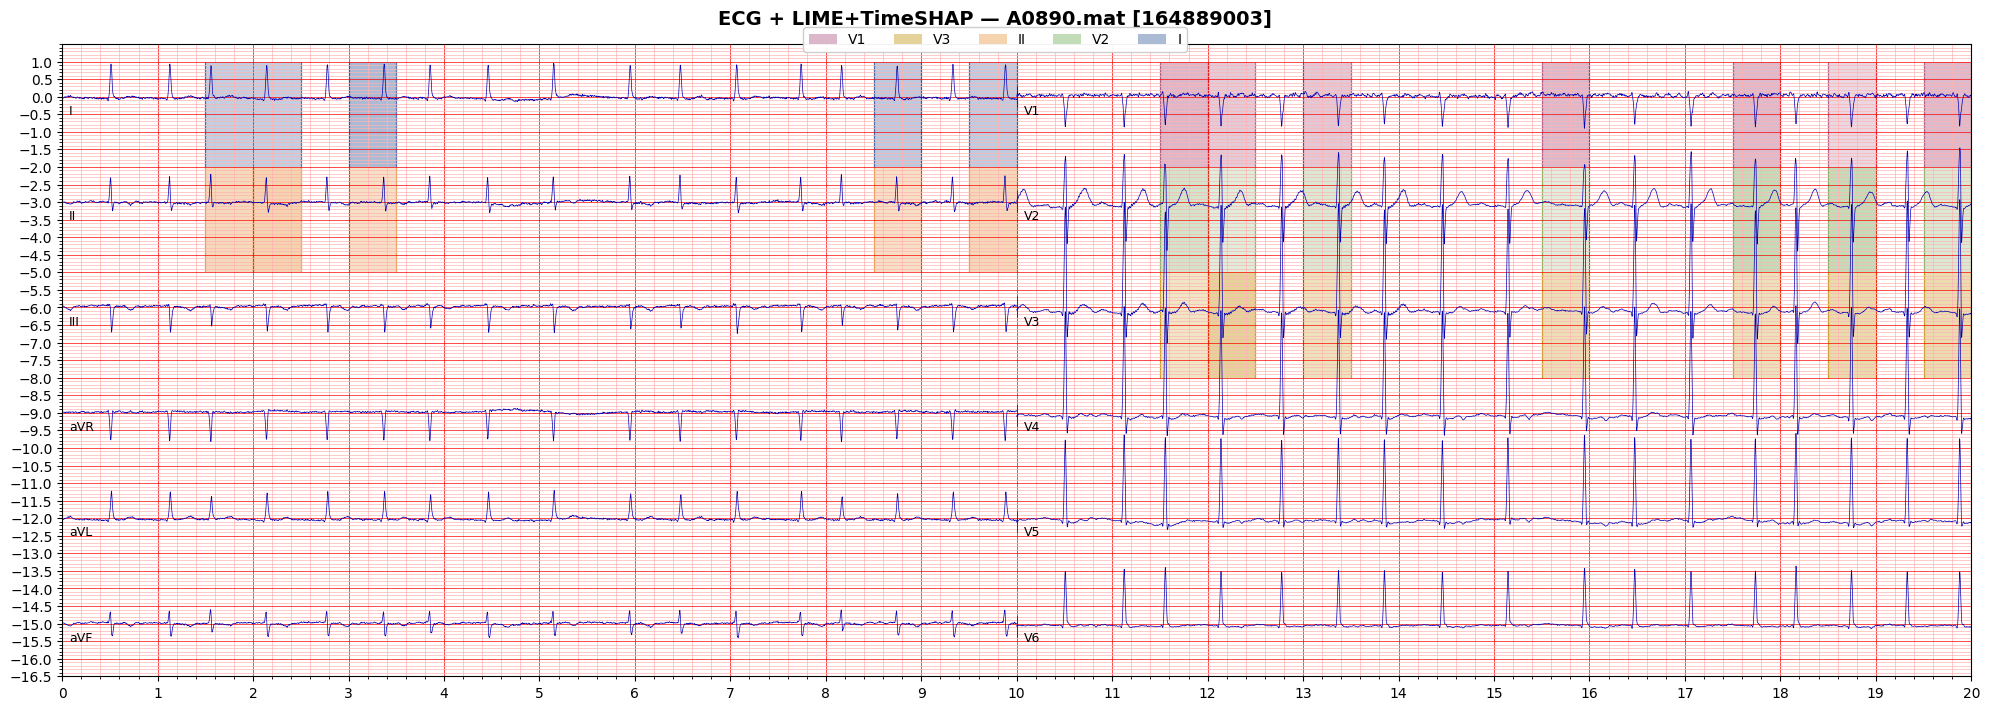

<Figure size 2000x600 with 0 Axes>

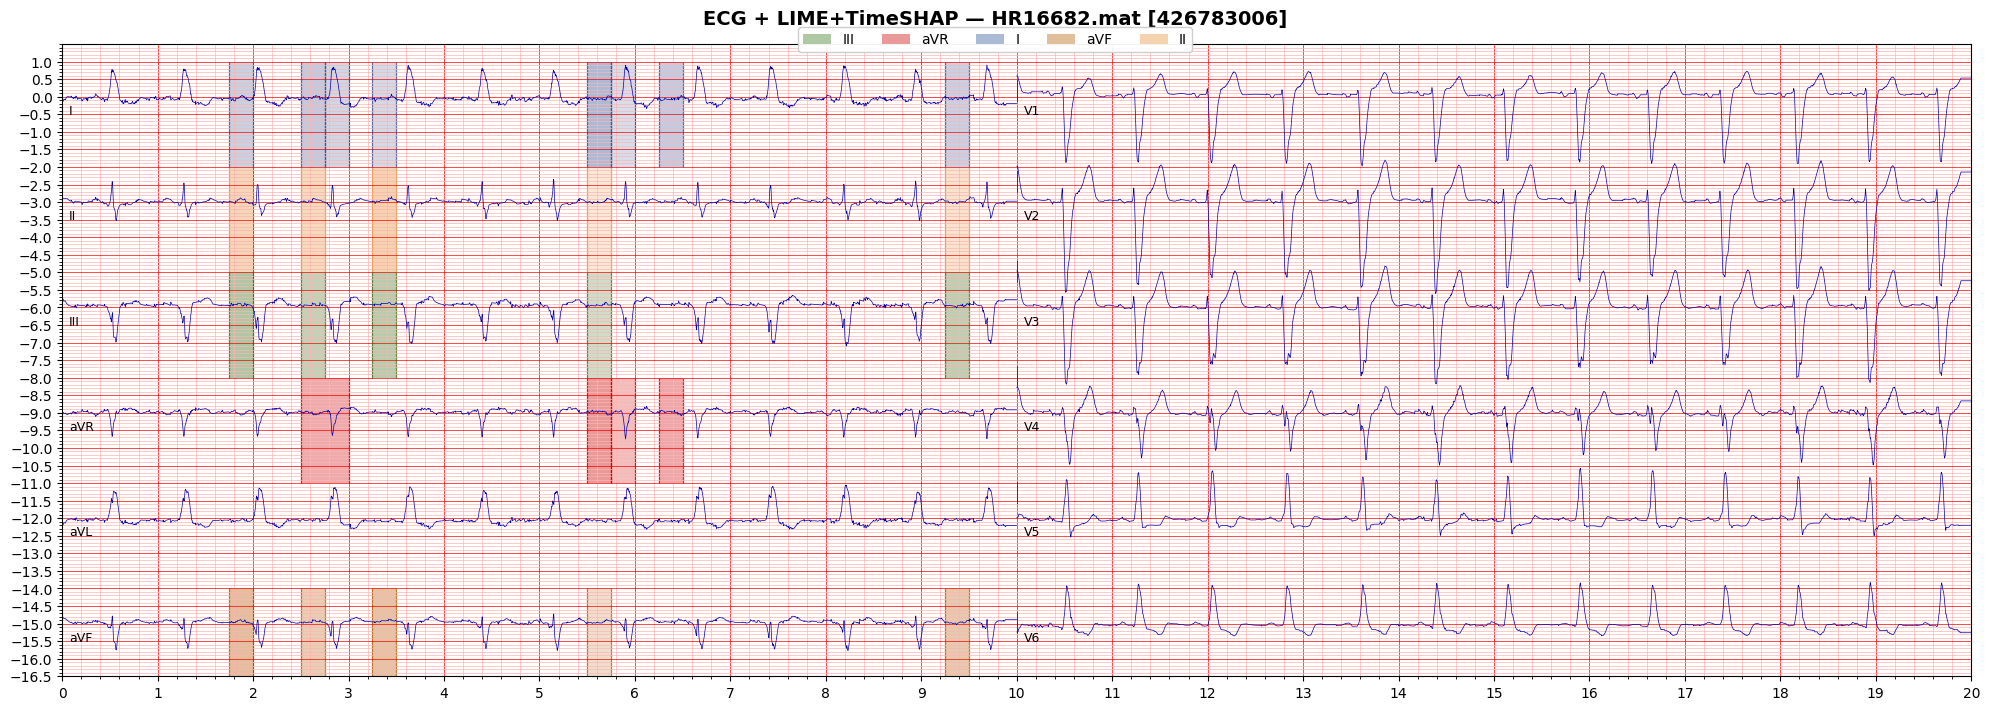

<Figure size 2000x600 with 0 Axes>

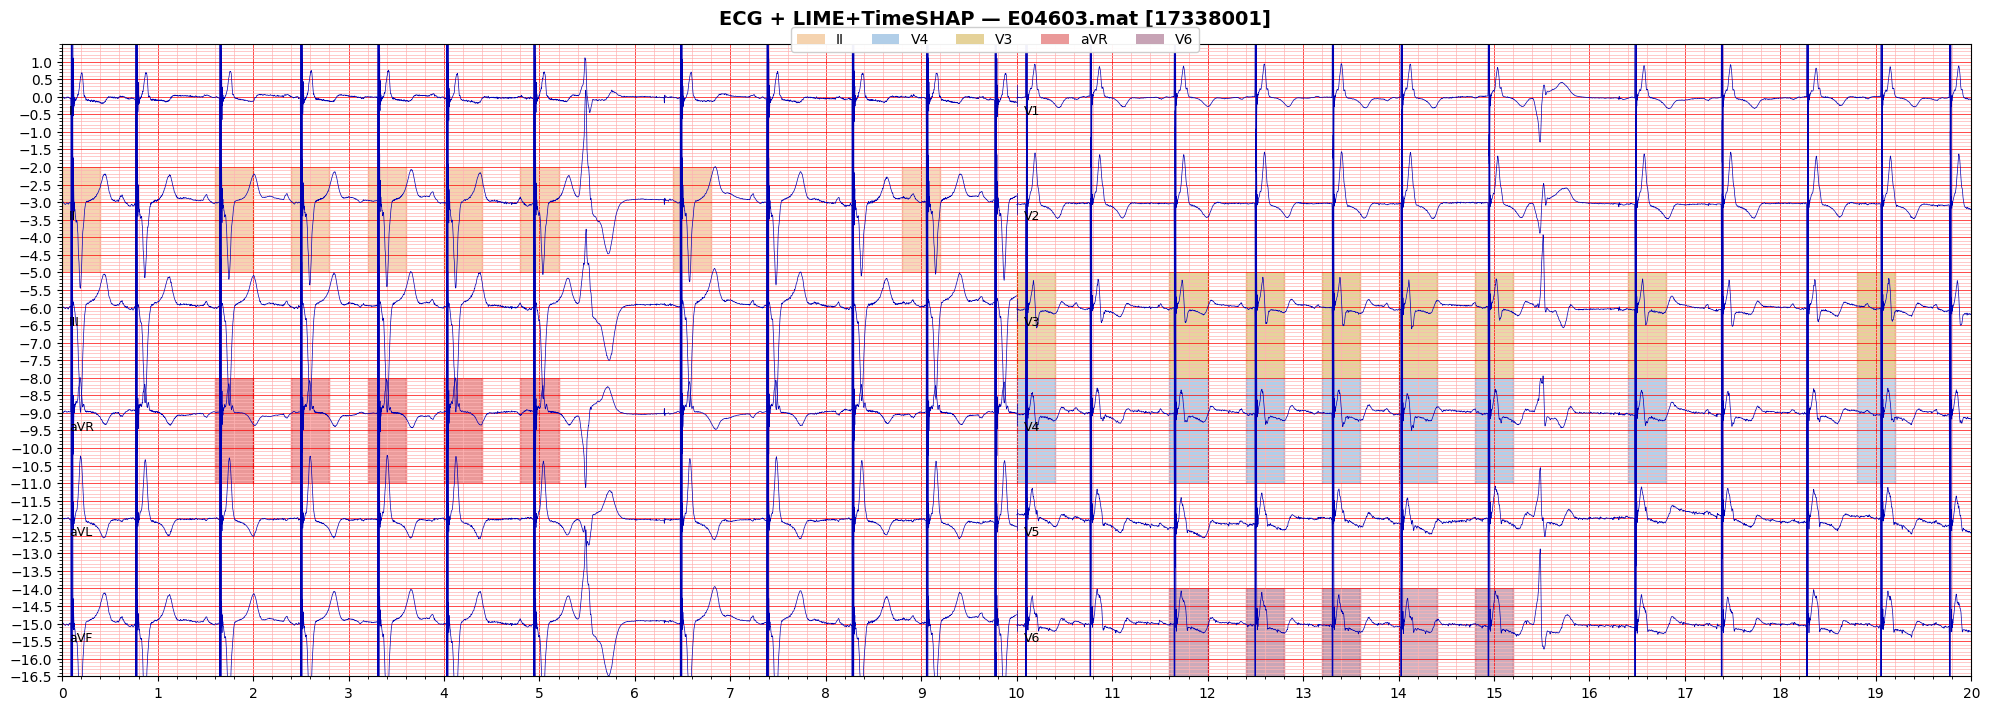

In [5]:
target_classes = list(TARGET_META.keys())   # ["164889003", "426783006", "17338001"]

print("Target classes:", target_classes)

all_fused_payloads, df_lime_all, df_ts_all = run_fused_pipeline_for_classes(
    target_classes=target_classes,
    sel_df=sel_df,
    model=model,
    class_names=class_names,
    max_examples_per_class=1,
    plot=True,
)

In [6]:
df_eval_all = evaluate_all_payloads(
    all_payloads=all_fused_payloads,
    method_label="LIME+TimeSHAP",
    debug=False,
    model=model,
    class_names=class_names,
)

df_eval_all

,meta_code,class_name,sel_idx,mat_path,method,strict_attauc,lenient_attauc,strict_f1,lenient_f1,deletion_auc,faithfulness_gain,n_tokens
0,164889003,atrial fibrillation,4342,C:\data\china-physiological-signal-challenge-i...,LIME+TimeSHAP,0.913581,0.62965,0.656250,0.8,0.276823,0.064892,204
1,426783006,sinus rhythm,37871,C:\data\ptbxl-electrocardiography-database\WFD...,LIME+TimeSHAP,0.836391,1.00000,0.571429,1.0,0.260851,0.023088,156
2,17338001,ventricular premature beats,14932,C:\data\georgia-12lead-ecg-challenge-database\...,LIME+TimeSHAP,0.836741,1.00000,0.750000,1.0,0.299931,0.000048,288


### Stability to an Extra Heartbeat (All Target Classes)

We assess explanation stability under a synthetic perturbation where one existing
heartbeat is duplicated and re-inserted either at the **end** of the ECG or in
the **middle** of the recording.

For each target rhythm class in `TARGET_META`:

1. We take the example that was already explained and evaluated in `df_eval_all`.
2. We run `run_extra_beat_stability_experiment`, which:
   - creates two augmented versions of the ECG
     - one with an **extra beat appended at the end**
     - one with an **extra beat inserted in the middle**
   - recomputes **fused LIME + TimeSHAP** explanations for each version
   - compares region-level importance profiles over the *shared beats* using:
     - **Spearman rank correlation** (global ordering of important regions)
     - **Jaccard@K** overlap of the top-K most important regions.

This gives us per-class stability metrics for:

- original vs **extra-beat-at-end**
- original vs **extra-beat-in-middle**


In [7]:
target_classes = list(TARGET_META.keys())

stability_results = {}

for snomed_code in target_classes:
    snomed_code_str = str(snomed_code)

    # Pick the first evaluated example for this class
    df_cls = df_eval_all[df_eval_all.meta_code.astype(str) == snomed_code_str]

    if df_cls.empty:
        print(f"[WARN] No evaluated examples for class {snomed_code_str}, skipping.")
        continue

    row = df_cls.iloc[0]
    mat_path = row.mat_path
    class_name = TARGET_META[snomed_code_str]["name"]

    print(f"\n=== Running extra-beat stability for {snomed_code_str} ({class_name}) ===")
    print(f"MAT path: {mat_path}")

    metrics, sel_df_stab, fused_payloads_stab, df_lime_stab, df_ts_stab = run_extra_beat_stability_experiment(
        mat_path=mat_path,
        snomed_code=snomed_code_str,
        model=model,
        class_names=class_names,
    )

    stability_results[snomed_code_str] = {
        "name": class_name,
        "mat_path": mat_path,
        "metrics": metrics,
    }

stability_results




=== Running extra-beat stability for 164889003 (atrial fibrillation) ===
MAT path: C:\data\china-physiological-signal-challenge-in-2018\Training_WFDB\A0890.mat

=== Running extra-beat stability for 426783006 (sinus rhythm) ===
MAT path: C:\data\ptbxl-electrocardiography-database\WFDB\HR16682.mat

=== Running extra-beat stability for 17338001 (ventricular premature beats) ===
MAT path: C:\data\georgia-12lead-ecg-challenge-database\Georgia\E04603.mat


{'164889003': {'name': 'atrial fibrillation',
  'mat_path': 'C:\\data\\china-physiological-signal-challenge-in-2018\\Training_WFDB\\A0890.mat',
  'metrics': {'extra_end': {'spearman': 1.0, 'jaccard_topk': 1.0},
   'extra_mid': {'spearman': 0.9413197907323722, 'jaccard_topk': 0.6}}},
 '426783006': {'name': 'sinus rhythm',
  'mat_path': 'C:\\data\\ptbxl-electrocardiography-database\\WFDB\\HR16682.mat',
  'metrics': {'extra_end': {'spearman': 0.9999999999999998,
    'jaccard_topk': 1.0},
   'extra_mid': {'spearman': 0.9206382077417207,
    'jaccard_topk': 0.5384615384615384}}},
 '17338001': {'name': 'ventricular premature beats',
  'mat_path': 'C:\\data\\georgia-12lead-ecg-challenge-database\\Georgia\\E04603.mat',
  'metrics': {'extra_end': {'spearman': 1.0, 'jaccard_topk': 1.0},
   'extra_mid': {'spearman': 0.9668648132933966,
    'jaccard_topk': 0.6666666666666666}}}}

### Stability Summary Table

To make the results easier to inspect and report, we summarise the stability
metrics for each target class in a single table.


In [14]:
rows = []

for code, info in stability_results.items():
    m = info["metrics"]
    m_end = m["extra_end"]
    m_mid = m["extra_mid"]

    rows.append({
        "SNOMED code": code,
        "Class name": info["name"],
        "Spearman (extra end)":  m_end["spearman"],
        "Jaccard@K (extra end)": m_end["jaccard_topk"],
        "Spearman (extra mid)":  m_mid["spearman"],
        "Jaccard@K (extra mid)": m_mid["jaccard_topk"],
    })

df_stability_summary = pd.DataFrame(rows)
df_stability_summary


,SNOMED code,Class name,Spearman (extra end),Jaccard@K (extra end),Spearman (extra mid),Jaccard@K (extra mid)
0,164889003,atrial fibrillation,1.0,1.0,0.941320,0.600000
1,426783006,sinus rhythm,1.0,1.0,0.920638,0.538462
2,17338001,ventricular premature beats,1.0,1.0,0.966865,0.666667


Overall, the fused explanations were **perfectly stable** to appending an
extra heartbeat at the end of the recording across all classes
(Spearman ≈ 1.0, Jaccard@K = 1.0). This indicates that adding extra context
at the tail of the ECG does not affect the explanations for the existing beats.

In contrast, inserting an extra beat in the middle of the recording led to
a reduction in stability. Spearman rank correlation remained high
(≈ 0.94–0.97), suggesting that the global ordering of important regions is
largely preserved, but Jaccard@K dropped (e.g. 0.33–0.60), indicating that the
exact composition of the top-K most important regions is more sensitive to
perturbations in the internal temporal structure of the signal.


In [15]:
import pandas as pd

# Group by SNOMED meta-code + human-readable name
summary = (
    df_eval_all
    .groupby(["meta_code", "class_name"])
    .agg(
        # --- AttAUC: ranking-based localisation accuracy ---
        strict_attauc_mean=("strict_attauc", "mean"),
        strict_attauc_std=("strict_attauc", "std"),
        lenient_attauc_mean=("lenient_attauc", "mean"),
        lenient_attauc_std=("lenient_attauc", "std"),

        # --- F1: threshold-based localisation accuracy ---
        strict_f1_mean=("strict_f1", "mean"),
        strict_f1_std=("strict_f1", "std"),
        lenient_f1_mean=("lenient_f1", "mean"),
        lenient_f1_std=("lenient_f1", "std"),

        # --- Deletion AUC: faithfulness (lower is better) ---
        deletion_auc_mean=("deletion_auc", "mean"),
        deletion_auc_std=("deletion_auc", "std"),

        # Token count (just descriptive)
        n_tokens_mean=("n_tokens", "mean"),
        n_tokens_std=("n_tokens", "std"),
    )
    .reset_index()
)

summary


,meta_code,class_name,strict_attauc_mean,strict_attauc_std,lenient_attauc_mean,lenient_attauc_std,strict_f1_mean,strict_f1_std,lenient_f1_mean,lenient_f1_std,deletion_auc_mean,deletion_auc_std,n_tokens_mean,n_tokens_std
0,164889003,atrial fibrillation,0.913581,NaN,0.62965,NaN,0.656250,NaN,0.8,NaN,0.276823,NaN,204.0,NaN
1,17338001,ventricular premature beats,0.836741,NaN,1.00000,NaN,0.750000,NaN,1.0,NaN,0.299931,NaN,288.0,NaN
2,426783006,sinus rhythm,0.836391,NaN,1.00000,NaN,0.571429,NaN,1.0,NaN,0.260851,NaN,156.0,NaN


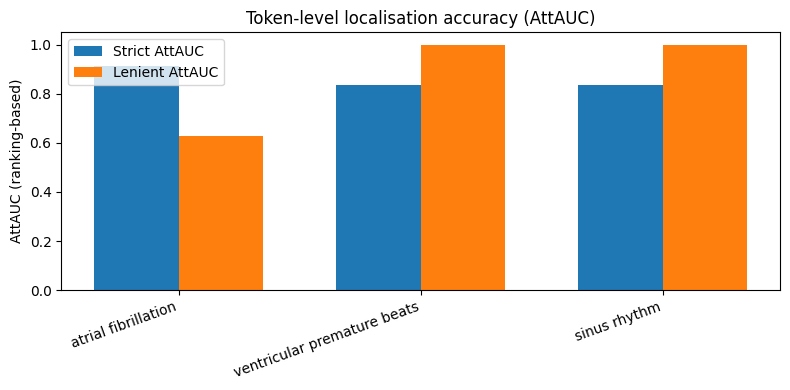

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# For nicer x-axis labels
classes = summary["class_name"].values
x = np.arange(len(classes))
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(8, 4))

# Strict AttAUC: explainer vs strict, narrow definition of "correct"
ax.bar(
    x - width/2,
    summary["strict_attauc_mean"],
    width,
    yerr=summary["strict_attauc_std"],
    capsize=4,
    label="Strict AttAUC",
)

# Lenient AttAUC: explainer vs broader, more forgiving ground truth
ax.bar(
    x + width/2,
    summary["lenient_attauc_mean"],
    width,
    yerr=summary["lenient_attauc_std"],
    capsize=4,
    label="Lenient AttAUC",
)

ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=20, ha="right")
ax.set_ylabel("AttAUC (ranking-based)")
ax.set_ylim(0, 1.05)
ax.set_title("Token-level localisation accuracy (AttAUC)")
ax.legend()
plt.tight_layout()
plt.show()


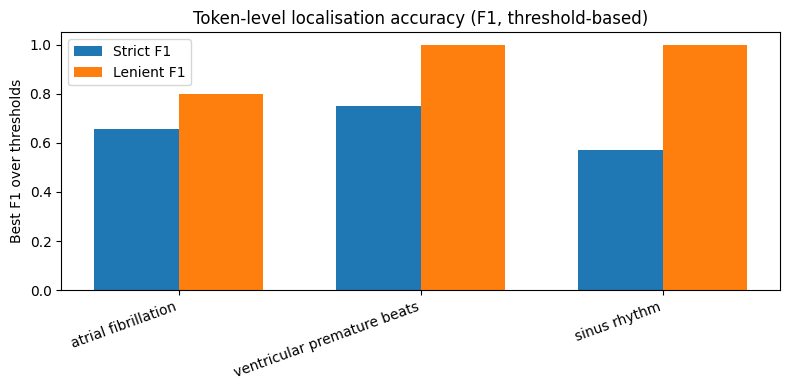

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(
    x - width/2,
    summary["strict_f1_mean"],
    width,
    yerr=summary["strict_f1_std"],
    capsize=4,
    label="Strict F1",
)

ax.bar(
    x + width/2,
    summary["lenient_f1_mean"],
    width,
    yerr=summary["lenient_f1_std"],
    capsize=4,
    label="Lenient F1",
)

ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=20, ha="right")
ax.set_ylabel("Best F1 over thresholds")
ax.set_ylim(0, 1.05)
ax.set_title("Token-level localisation accuracy (F1, threshold-based)")
ax.legend()
plt.tight_layout()
plt.show()


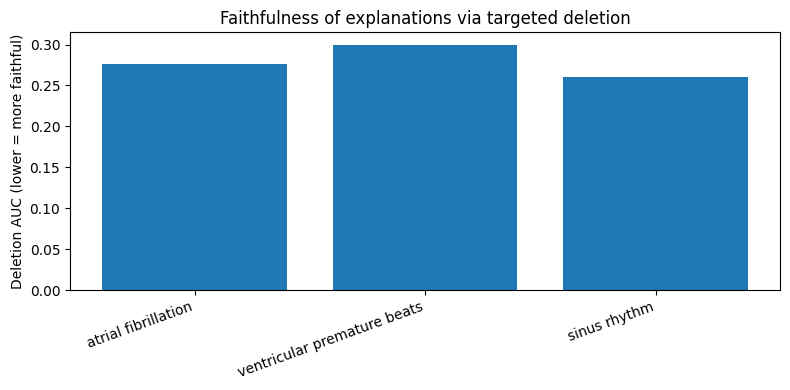

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))

# Lower deletion AUC => more faithful (probability drops faster)
ax.bar(
    x,
    summary["deletion_auc_mean"],
    yerr=summary["deletion_auc_std"],
    capsize=4,
)

ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=20, ha="right")
ax.set_ylabel("Deletion AUC (lower = more faithful)")
ax.set_title("Faithfulness of explanations via targeted deletion")
plt.tight_layout()
plt.show()


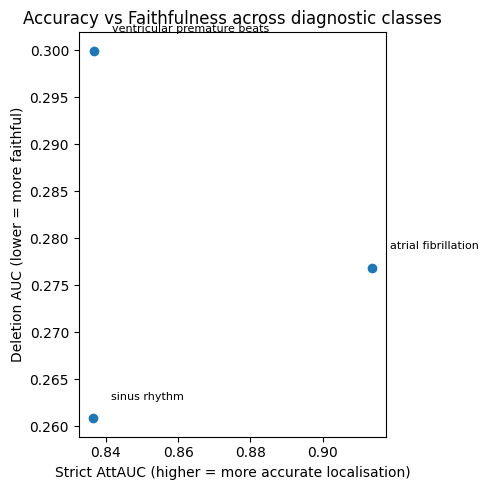

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

# Use strict AttAUC on x-axis and deletion AUC on y-axis
ax.scatter(
    summary["strict_attauc_mean"],
    summary["deletion_auc_mean"],
)

for _, row in summary.iterrows():
    ax.text(
        row["strict_attauc_mean"] + 0.005,
        row["deletion_auc_mean"] + 0.002,
        row["class_name"],
        fontsize=8,
    )

ax.set_xlabel("Strict AttAUC (higher = more accurate localisation)")
ax.set_ylabel("Deletion AUC (lower = more faithful)")
ax.set_title("Accuracy vs Faithfulness across diagnostic classes")
plt.tight_layout()
plt.show()
